# OP2: Numpy Demo #1 (Displacement, Solid Stress)

The Jupyter notebook for this demo can be found in:
   - docs/quick_start/demo/op2_demo_numpy2.ipynb
   - https://github.com/SteveDoyle2/pyNastran/tree/master/docs/quick_start/demo/op2_demo_numpy2.ipynb

It's recommended that you first go through:
   - https://github.com/SteveDoyle2/pyNastran/tree/master/docs/quick_start/demo/op2_intro.ipynb

The previous demo was intentionally clunky to demonstrate how one might think of a single element. 

If you code like that, your code will be slow, so let's show you how to really use the numpy-style with the OP2.

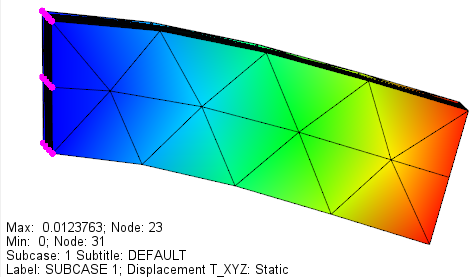

### Import the packages

In [1]:
import os
import copy
import numpy as np
np.set_printoptions(precision=2, threshold=20, suppress=True, linewidth=100)

import pyNastran
pkg_path = pyNastran.__path__[0]
model_path = os.path.join(pkg_path, '..', 'models')

from pyNastran.utils import print_bad_path
from pyNastran.op2.op2 import read_op2
from pyNastran.utils import object_methods, object_attributes
np.set_printoptions(precision=3, threshold=20, edgeitems=10)

### Load the model

In [2]:
op2_filename = os.path.join(model_path, 'solid_bending', 'solid_bending.op2')
model = read_op2(op2_filename, build_dataframe=False, debug=False)

### Find the min/max Displacement magnitude

In this example, we access the 3D "data" numpy array object.  Then we take the L2-norm of the translations to determine the magnitude.  We broadcast the L2-norm across the column (x, y, z) to end up with **nnodes** results.  It's good practice to verify the shapes of your arrays just to make sure you get the **axis=1** parameter correct.  

In [3]:
subcase_id = 1
disp = model.displacements[subcase_id]
disp_headers = disp.get_headers()
print('disp_headers = %s' % disp_headers)
nnodes = disp.node_gridtype.shape[0]

txyz = disp.data[0, :, :3]
txyz_mag = np.linalg.norm(txyz, axis=1)
assert len(txyz_mag) == nnodes
txyz_mag_max = txyz_mag.max()
txyz_mag_min = txyz_mag.min()

inid_max = np.where(txyz_mag == txyz_mag_max)[0]
inid_min = np.where(txyz_mag == txyz_mag_min)[0]
all_nodes = disp.node_gridtype[:, 0]
max_nodes = all_nodes[inid_max]
min_nodes = all_nodes[inid_min]
print('max displacement=%s max_nodes=%s' % (txyz_mag_max, max_nodes))
print('min displacement=%s min_nodes=%s' % (txyz_mag_min, min_nodes))

disp_headers = ['t1', 't2', 't3', 'r1', 'r2', 'r3']
max displacement=0.012376265 max_nodes=[23]
min displacement=0.0 min_nodes=[31 35 39 43 47 48 53 63 64 69 70 71 72]


### Find the max centroidal stress on the CTETRA elements

In [4]:
subcase_id = 1
stress = model.op2_results.stress
stressi = stress.ctetra_stress[subcase_id]


In [5]:
stress_headers = stressi.get_headers()
print('stress_headers = %s' % stress_headers)

element_node = stressi.element_node
elements = element_node[:, 0]
nodes = element_node[:, 1]
#print(element_node)

stress_headers = ['oxx', 'oyy', 'ozz', 'txy', 'tyz', 'txz', 'omax', 'omid', 'omin', 'von_mises']


### The 0 location is the centroid

You can either query the 0 location or calculate it with a numpy arange.  CTETRA elements have 4 nodes (even 10 noded CTETRA elements) in the OP2.

In [6]:
izero = np.where(nodes == 0)[0]
izero2 = np.arange(0, len(nodes), step=5, dtype='int32')
#print(izero)
#print(izero2)
eids_centroid = elements[izero2]
print('eids_centroid = %s' % eids_centroid)

ivm = stress_headers.index('von_mises')
vm_stress = stressi.data[0, izero2, ivm]
print(vm_stress)

vm_stress_max = vm_stress.max()
vm_stress_min = vm_stress.min()
icentroid_max = np.where(vm_stress == vm_stress_max)[0]
icentroid_min = np.where(vm_stress == vm_stress_min)[0]
eids_max = eids_centroid[icentroid_max]
eids_min = eids_centroid[icentroid_min]

print('max_stress=%s eids=%s' % (vm_stress_max, eids_max))
print('min_stress=%s eids=%s' % (vm_stress_min, eids_min))

eids_centroid = [  1   2   3   4   5   6   7   8   9  10 ... 177 178 179 180 181 182 183 184 185 186]
[15900.173 16272.253 12798.722 10728.189 26309.43  30346.639 45438.992 51427.406 40912.426
 41191.414 ...  7342.325 10163.439 28830.463 46618.023  6998.956  7861.917  8589.076  6053.971
 44450.695 22886.705]
max_stress=52446.37 eids=[142]
min_stress=3288.5732 eids=[165]


## Finding the VM stress associated with a single node ID

One node in a tet mesh may be shared by many elements.  In this case, 26 elements share 1 node!

In [7]:
stress_headers = stressi.get_headers()
print('stress_headers = %s' % stress_headers)

element_node = stressi.element_node
elements = element_node[:, 0]
nelements = len(elements) // 5
nodes = element_node[:, 1]#.reshape(nelements, 5)

#------------------------------
ivm = -1
print('nodes =', nodes)
ifour = np.where(nodes == 4)[0]
eids_four = elements[ifour].tolist()
print('eids4 =', eids_four)
print('ifour =', ifour)
vm_stress = stressi.data[0, ifour, ivm]
print('vm_stress =', vm_stress, len(vm_stress))

stress_headers = ['oxx', 'oyy', 'ozz', 'txy', 'tyz', 'txz', 'omax', 'omid', 'omin', 'von_mises']
nodes = [ 0  8 13 67 33  0  8  7 62 59 ...  0 54 39 64 71  0  8 62  4 58]
eids4 = [15, 17, 35, 36, 37, 38, 39, 40, 52, 69, 75, 80, 81, 83, 84, 93, 94, 109, 110, 112, 119, 140, 147, 158, 174, 186]
ifour = [ 72  82 171 176 181 186 191 196 256 341 ... 468 542 546 557 594 698 733 786 866 928]
vm_stress = [14743.482 15626.162  8966.338 30538.127 30699.877 22275.338 10997.474 14971.115  8662.346
  7466.423 ... 21431.023 10285.905 14731.244  9881.857 15744.815  9625.97  11964.446 12875.621
  8207.951 22886.705] 26


## Finding the centroidal VM stress for a set of elements

Some fancy numpy code will be used for this case.  Your code will be much faster if you are familiar with numpy.

In [8]:
stress_headers = stressi.get_headers()
print('stress_headers = %s' % stress_headers)

element_node = stressi.element_node
elements = element_node[:, 0]
nodes = element_node[:, 1]

# the slow way to get the unique elements
izero = np.where(nodes == 0)[0]
ueids_slow = elements[izero]

# the fast way
ueids = np.unique(elements)
assert np.array_equal(ueids, ueids_slow)

eids_to_lookup = [5, 7, 10]
ilookup = np.searchsorted(ueids, eids_to_lookup)

ivm = stress_headers.index('von_mises')
vm_stress = stressi.data[0, ilookup, ivm]

print('eids_to_lookup =', eids_to_lookup)
print('vm_stress =', vm_stress)

stress_headers = ['oxx', 'oyy', 'ozz', 'txy', 'tyz', 'txz', 'omax', 'omid', 'omin', 'von_mises']
eids_to_lookup = [5, 7, 10]
vm_stress = [15900.173 16272.253 16272.253]


## Finding the centroidal VM stress for a set of elements when you have multiple element types

In this case, we'll assume the set of element_ids to lookup contain CHEXAs as well as CTETRAs.
Thus, we need to filter the data.

In [9]:
subcase_id = 1
stress_headers = stressi.get_headers()
print('stress_headers = %s' % stress_headers)

element_node = stressi.element_node
elements = element_node[:, 0]
nodes = element_node[:, 1]

ueids = np.unique(elements)
print('ueids', ueids)
eids_to_lookup = [5, 7, 10, 186, 1000000]
ilookup = np.searchsorted(ueids, eids_to_lookup)

ivm = stress_headers.index('von_mises')
vm_stress = stressi.data[0, ilookup, ivm]

print('eids_to_lookup =', eids_to_lookup)
print('vm_stress =', vm_stress)

stress_headers = ['oxx', 'oyy', 'ozz', 'txy', 'tyz', 'txz', 'omax', 'omid', 'omin', 'von_mises']
ueids [  1   2   3   4   5   6   7   8   9  10 ... 177 178 179 180 181 182 183 184 185 186]
eids_to_lookup = [5, 7, 10, 186, 1000000]
vm_stress = [15900.173 16272.253 16272.253 22275.338 22275.338]


### We have a problem where our element_id (1000000) is out of range

Searchsorted is fast, but you need to make sure your data actually exists.  Otherwise, you'll end
up finding the data for the next element in the sorted list.

Let's filter the data using sets and then use searchsorted.

In [10]:
eids_to_lookup = [5, 7, 10, 186, 1000000]
filtered_eids = np.intersect1d(elements, eids_to_lookup)
ilookup = np.searchsorted(ueids, filtered_eids)
vm_stress = stressi.data[0, ilookup, ivm]

print('filtered_eids =', filtered_eids)
print('vm_stress =', vm_stress)

filtered_eids = [  5   7  10 186]
vm_stress = [15900.173 16272.253 16272.253 22275.338]


### Other Elements that are Similar

 - Rod Stress/strain
 - Beam Stress/strain
 - Bar Stress/strain
 - Isotropic CQUAD4 stress/strain